# Transfer Learning Job Profiles

The following graphs and statistics capture the profile of the transfer learning experiments.

In [257]:
# NOTEBOOK VARIABLES

experiment = "unsharded_2"
clusters_file = "clusters.csv"

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dir_prefix = "experiment_data/job_profiles"
clusters_df = pd.read_csv(f"{dir_prefix}/{clusters_file}", header=0)
tasks_df = pd.read_csv(f"{dir_prefix}/{experiment}.csv", header=1)
iterations_df = pd.read_csv(f"{dir_prefix}/{experiment}_iterations.csv", header=0)

iterations_df

,gis_join,iterations,is_center
0,G0500330,1,True
1,G5600050,1,True
2,G4600870,1,True
3,G5400770,1,True
4,G4100070,1,True
...,...,...,...
3060,G2601170,1,False
3061,G1800650,1,False
3062,G3901730,1,False
3063,G3900110,1,False


In [215]:
def human_time(difference_ms):
    return datetime.timedelta(milliseconds=difference_ms)

class Cluster:
    
    def __init__(self, cluster_id):
        self.id = cluster_id
        self.gis_joins = []
        self.center_gis_join = ""
        

class Task:
    
    def __init__(self, task_id, name, begin, end, time_seconds, gis_join="", cluster_id=-1):
        self.id = task_id
        self.name = name
        self.begin = begin
        self.end = end
        self.time_seconds = time_seconds
        self.gis_join = gis_join
        self.cluster_id = cluster_id
        
    def __repr__(self):
        return repr(f"Task: id={self.id}, name={self.name}, begin={self.begin}, end={self.end}, time_seconds={self.time_seconds}")
    
    
class CentroidModelTasks:
    
    def __init__(self):
        self.run_tasks = []
        self.checkpoint_tasks = []
        self.fit_tasks = []
        self.evaluate_tasks = []
        
        
class ClusterLRModelTasks:
    
    def __init__(self):
        self.run_tasks = {}
        self.persist_tasks = {}
        self.checkpoint_tasks = {}
        self.fit_tasks = {}
        self.evaluate_tasks = {}
        
        

In [216]:
experiment = None
centroid_model_tasks = CentroidModelTasks()
cluster_lr_model_tasks = ClusterLRModelTasks()
clusters = {}

In [217]:
for i, row in clusters_df.iterrows():
    cluster_id = row["cluster_id"]
    if cluster_id not in clusters:
        clusters[cluster_id] = Cluster(cluster_id)
    
    if row["is_center"]:
        clusters[cluster_id].center_gis_join = row["gis_join"]
    else:
        clusters[cluster_id].gis_joins.append(row["gis_join"])
        

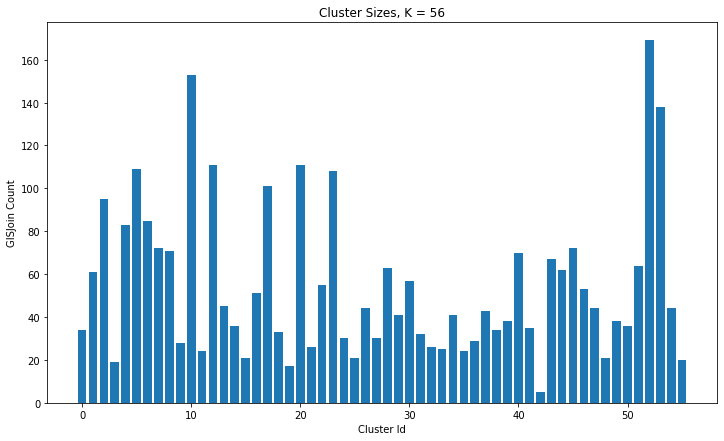

In [218]:
# ---- Plot Clusters Bar Chart -----

cluster_sizes = [len(clusters[cluster_id].gis_joins)+1 for cluster_id in clusters]
plt.figure(figsize=(12,7))
plt.bar(range(0, len(clusters)), cluster_sizes)
plt.title("Cluster Sizes, K = 56")
plt.xlabel("Cluster Id")
plt.ylabel("GISJoin Count")
plt.show()

In [219]:
for i, row in tasks_df.iterrows():
    if (i == 0):
        experiment = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        task_cluster_id = str(parts[3][len("clusterId="):])
        
        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)
        
        if (task_type == "CentroidModel"):
            
            if ("run(" in task_name):
                centroid_model_tasks.run_tasks.append(new_task)
            elif ("Filter" in task_name):
                centroid_model_tasks.checkpoint_tasks.append(new_task)
            elif ("Fit" in task_name):
                centroid_model_tasks.fit_tasks.append(new_task)
            elif ("Evaluate" in task_name):
                centroid_model_tasks.evaluate_tasks.append(new_task)
                
        elif (task_type == "ClusterLRModels"):
            
            if ("run(" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.run_tasks:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id].append(new_task)
                    
            elif ("Cluster" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.persist_tasks:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id].append(new_task)
                    
            elif ("Filter" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.checkpoint_tasks:
                    cluster_lr_model_tasks.checkpoint_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.checkpoint_tasks[task_cluster_id].append(new_task)
                    
            elif ("Fit" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.fit_tasks:
                    cluster_lr_model_tasks.fit_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.fit_tasks[task_cluster_id].append(new_task)
                    
            elif ("Evaluate" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.evaluate_tasks:
                    cluster_lr_model_tasks.evaluate_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.evaluate_tasks[task_cluster_id].append(new_task)
        

Total time taken to train/evaluate 56 centroid models: 0:19:16.441000


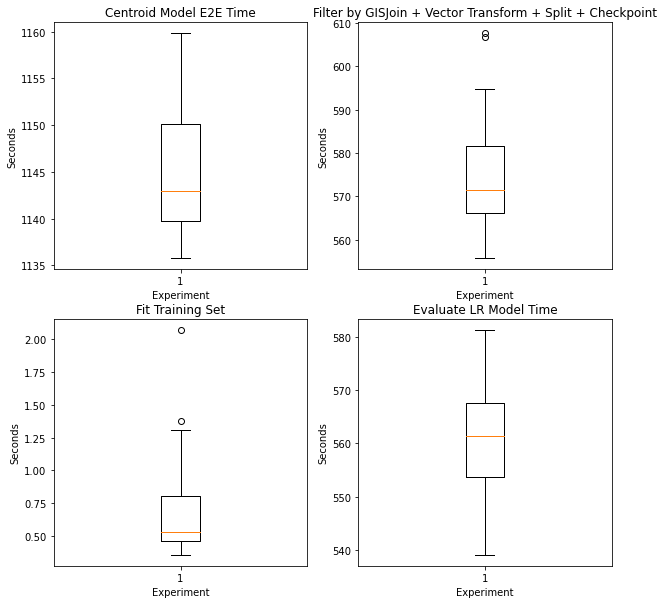

In [222]:
# ---- Centroid Models Plotting -----

centroid_run_tasks = [task.time_seconds for task in centroid_model_tasks.run_tasks]
centroid_checkpoint_tasks = [task.time_seconds for task in centroid_model_tasks.checkpoint_tasks]
centroid_fit_tasks = [task.time_seconds for task in centroid_model_tasks.fit_tasks]
centroid_eval_tasks = [task.time_seconds for task in centroid_model_tasks.evaluate_tasks]

total_centroid_time = human_time(centroid_model_tasks.evaluate_tasks[-1].end 
                                 - centroid_model_tasks.run_tasks[0].begin)

print("Total time taken to train/evaluate 56 centroid models:", total_centroid_time)


# Create a figure
figure, axis = plt.subplots(2, 2, figsize=(10,10))


# For Total End-to-End Time
axis[0, 0].boxplot(centroid_run_tasks)
axis[0, 0].set_title("Centroid Model E2E Time")
axis[0, 0].set_ylabel("Seconds")
axis[0, 0].set_xlabel("Experiment")
  
# For Persist Task
axis[0, 1].boxplot(centroid_checkpoint_tasks)
axis[0, 1].set_title(centroid_model_tasks.checkpoint_tasks[0].name)
axis[0, 1].set_ylabel("Seconds")
axis[0, 1].set_xlabel("Experiment")
  
# For Split Test/Train Data and LR Fit
axis[1, 0].boxplot(centroid_fit_tasks)
axis[1, 0].set_title(centroid_model_tasks.fit_tasks[0].name)
axis[1, 0].set_ylabel("Seconds")
axis[1, 0].set_xlabel("Experiment")
  
# For Evaluate LR Model
axis[1, 1].boxplot(centroid_eval_tasks)
axis[1, 1].set_title("Evaluate LR Model Time")
axis[1, 1].set_ylabel("Seconds")
axis[1, 1].set_xlabel("Experiment")

# show plot
plt.show()

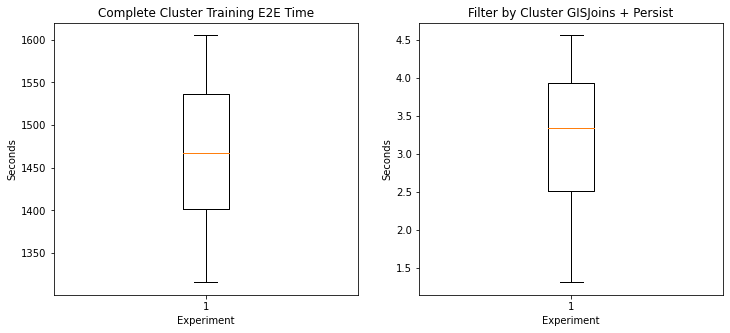

In [252]:
# ---- Cluster Transfer Learning Model Plotting -----

clusters_run_time_seconds = [val[0].time_seconds for val in cluster_lr_model_tasks.run_tasks.values()]
clusters_persist_seconds  = [val[0].time_seconds for val in cluster_lr_model_tasks.persist_tasks.values()]
    
# Create a figure
figure, axis = plt.subplots(1, 2, figsize=(12,5))

# For Cluster Training End-to-End Time
axis[0].boxplot(clusters_run_time_seconds)
axis[0].set_title("Complete Cluster Training E2E Time")
axis[0].set_ylabel("Seconds")
axis[0].set_xlabel("Experiment")
  
# For Dataframe Transform & Persist
axis[1].boxplot(clusters_persist_seconds)
axis[1].set_title("Filter by Cluster GISJoins + Persist")
axis[1].set_ylabel("Seconds")
axis[1].set_xlabel("Experiment")

plt.show()

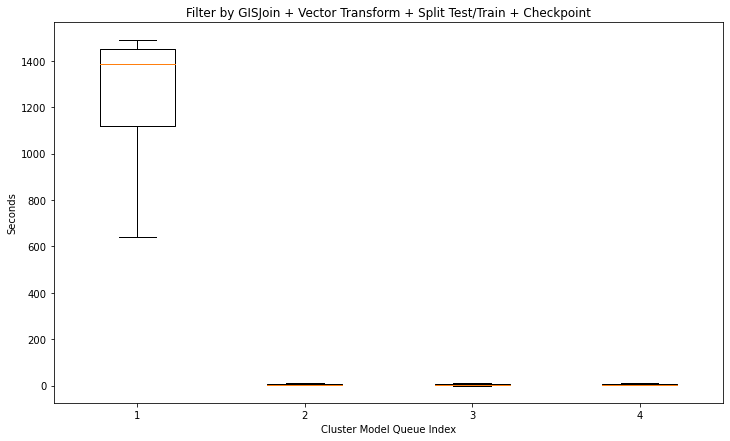

In [249]:
num_steps = 4
model_seconds = []
for i in range(0, num_steps):
    model_seconds.append([])
    for cluster_id, tasks in cluster_lr_model_tasks.checkpoint_tasks.items():
        model_seconds[i].append(tasks[i].time_seconds)

plt.figure(figsize=(12,7))
plt.boxplot(model_seconds)
plt.title("Filter by GISJoin + Vector Transform + Split Test/Train + Checkpoint")
plt.ylabel("Seconds")
plt.xlabel("Cluster Model Queue Index")
plt.show()

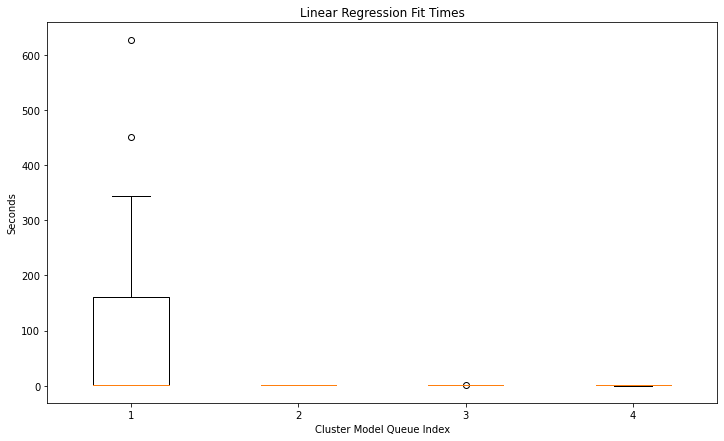

In [248]:
num_steps = 4
model_seconds = []
for i in range(0, num_steps):
    model_seconds.append([])
    for cluster_id, tasks in cluster_lr_model_tasks.fit_tasks.items():
        model_seconds[i].append(tasks[i].time_seconds)

plt.figure(figsize=(12,7))
plt.boxplot(model_seconds)
plt.title("Linear Regression Fit Times")
plt.ylabel("Seconds")
plt.xlabel("Cluster Model Queue Index")
plt.show()

[  0.           1.01010101   2.02020202   3.03030303   4.04040404
   5.05050505   6.06060606   7.07070707   8.08080808   9.09090909
  10.1010101   11.11111111  12.12121212  13.13131313  14.14141414
  15.15151515  16.16161616  17.17171717  18.18181818  19.19191919
  20.2020202   21.21212121  22.22222222  23.23232323  24.24242424
  25.25252525  26.26262626  27.27272727  28.28282828  29.29292929
  30.3030303   31.31313131  32.32323232  33.33333333  34.34343434
  35.35353535  36.36363636  37.37373737  38.38383838  39.39393939
  40.4040404   41.41414141  42.42424242  43.43434343  44.44444444
  45.45454545  46.46464646  47.47474747  48.48484848  49.49494949
  50.50505051  51.51515152  52.52525253  53.53535354  54.54545455
  55.55555556  56.56565657  57.57575758  58.58585859  59.5959596
  60.60606061  61.61616162  62.62626263  63.63636364  64.64646465
  65.65656566  66.66666667  67.67676768  68.68686869  69.6969697
  70.70707071  71.71717172  72.72727273  73.73737374  74.74747475
  75.7575757

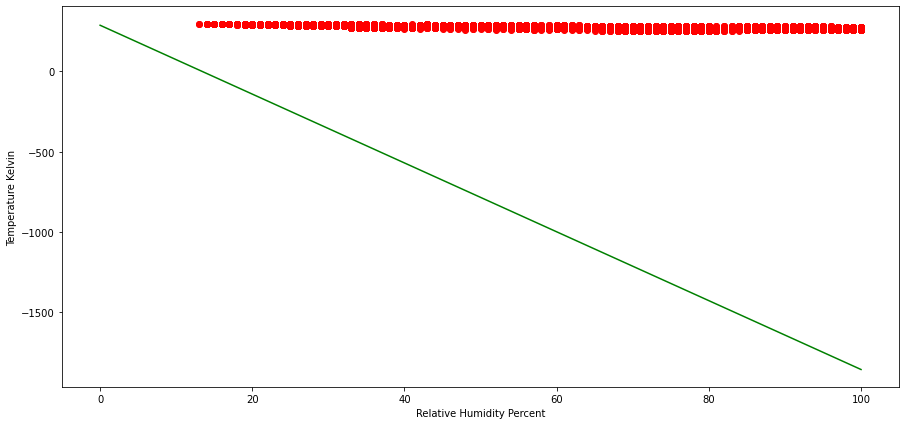

In [269]:
import numpy as np
gis_join_df = pd.read_csv("experiment_data/rows.csv", header=0)

X1 = gis_join_df["relative_humidity_percent"].to_list()
Y1 = gis_join_df["label"].to_list()

X2 = np.linspace(0, 100, 100)
Y2 = -21.42472705233258 * X2 + 287.2175

print(X2)

plt.figure(figsize=(15,7))
plt.plot(X1,Y1, "ro")
plt.plot(X2,Y2, "g-")
plt.xlabel("Relative Humidity Percent")
plt.ylabel("Temperature Kelvin")
plt.show()

